In [1]:
import pandas as pd
pd.set_option("display.max_columns", 100)
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, Any, Union

IN_CSV_DATA = Path().cwd().parent.parent / "data/3_feature_engineered"
OUT_CSV_DATA = Path().cwd().parent.parent / "data/3_feature_engineered"

In [2]:
df_summary = pd.read_csv(IN_CSV_DATA/'ride_summary_engineered.csv')
df_summary['start_date'] = pd.to_datetime(df_summary['start_date'])
df_summary['start_time'] = pd.to_datetime(df_summary['start_time'])
df_summary['end_time'] = pd.to_datetime(df_summary['end_time'])


In [ ]:
numerical_feature_cols = ['total_distance_mi','total_weight_lbs','avg_speed', 'avg_cruising_speed', 'total_ride_time_sec',
                            'total_moving_time_sec', 'total_ascent_ft', 'total_descent_ft', 'log_hours_since_last_ride',
                            'active_time_ratio', 'avg_climb_rate', 'distance_training_intensity','prior_training_load']
categorical_feature_cols = ['year','month_name', 'start_tod', 'start_dow']
target_cols = ['best_power_4s', 'best_power_5s',
                'best_power_10s', 'best_power_20s', 'best_power_30s', 'best_power_1m',
                'best_power_2m', 'best_power_3m', 'best_power_4m', 'best_power_5m',
                'best_power_6m', 'best_power_10m', 'best_power_20m', 'best_power_30m',
                'best_power_40m', 'best_power_1h', 'best_power_2h']

In [4]:
df_corr_numerical = df_summary[numerical_feature_cols].corr()

In [5]:
df_corr_targets = df_summary[target_cols].corr()

In [6]:
def plot_feature_corr(df_corr:pd.DataFrame, annotate:bool=False, fmt:str='0.2f'):
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(df_corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(8, 6))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    _ = sns.heatmap(df_corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=annotate, fmt=fmt)

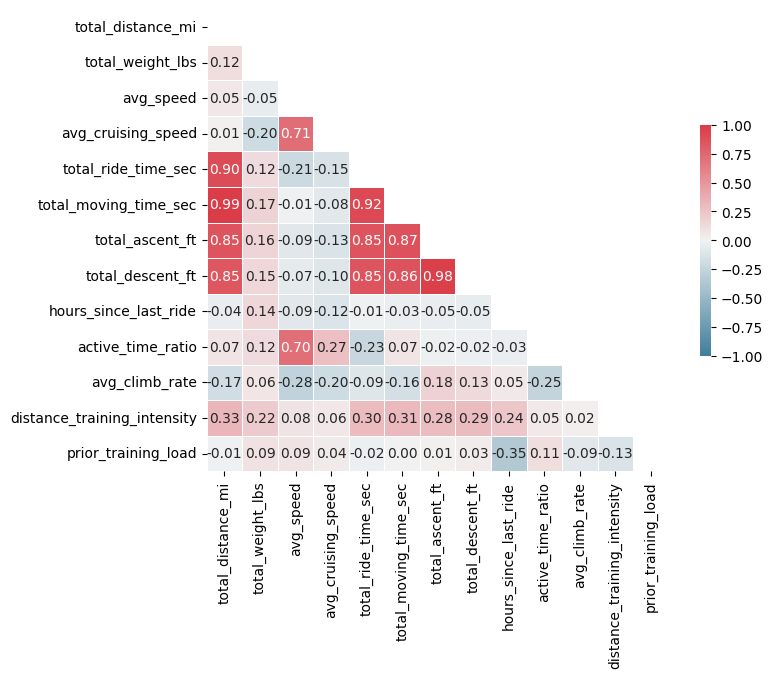

In [7]:
plot_feature_corr(df_corr_numerical, annotate=True)

## Observations:

1. `avg_cruising_speed` and `avg_speed` are too correlated, choose cruising speed for more accurate depiction of being in motion
2. The time and elevation (Ascent/Descent) columns are heavily correlated with `total_distance_miles`. This makes sense because these grow larger as distance increases. Together with an average speed column, the distance is sufficient to convey the effort required. Drop ride time / elevation columns
3. `active_time_ratio` is correlated with `avg_speed`. This makes sense based on the reality of starting and stopping a bunch causing a bunch of accel/deccel events which lower the average speed. Luckily `avg_cruising_speed` has a weak correlation. Keep `active_time_ratio`

No other numerical correlations jump out as potentially causing collinearity issues

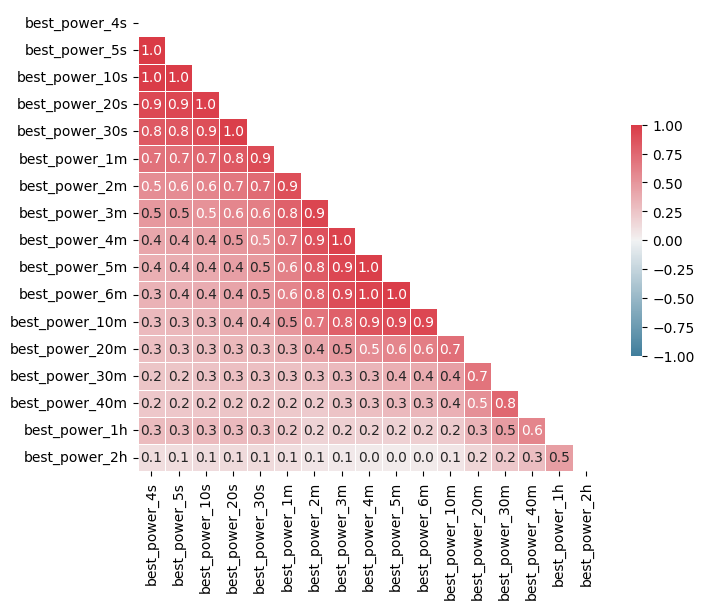

In [8]:
plot_feature_corr(df_corr_targets, annotate=True, fmt='0.1f')

**Observations:** the target columns are heavily correlated in certain regions. This makes sense based on the rolling window calculations. A high best_power in a 10 second window might also show up in the best 60 second window for example.

- Efforts from 4 seconds to 10 minutes are highly correlated. This means that when predicting the 10m effort, we can first predict the 6m effort and use it as a feature for the predictions. This is a Regression Chain. We can use the last predicted effort for the current one. This creates a first-order dependence on a chained regression. Even though many prior best effort durations might be correlated, we risk compounding errors if we choose too many prior predictions. 

- We also need to think about evaluation metrics, train-test split and regularization

In [9]:
ride_cols = ['ride_id','start_time']
numerical_feature_cols = ['total_distance_mi','total_weight_lbs','avg_cruising_speed', 'log_hours_since_last_ride',
                            'active_time_ratio', 'avg_climb_rate', 'distance_training_intensity','prior_training_load']
categorical_feature_cols = ['year']
target_cols = ['best_power_4s', 'best_power_5s',
                'best_power_10s', 'best_power_20s', 'best_power_30s', 'best_power_1m',
                'best_power_2m', 'best_power_3m', 'best_power_4m', 'best_power_5m',
                'best_power_6m', 'best_power_10m', 'best_power_20m', 'best_power_30m',
                'best_power_40m', 'best_power_1h', 'best_power_2h']

df_summary_selected = df_summary.copy()[ride_cols+numerical_feature_cols+categorical_feature_cols+target_cols]

In [10]:
df_summary_selected.to_csv(OUT_CSV_DATA / 'ride_summary_selected_feature.csv', index=False)

In [11]:
df_corr_numerical = df_summary_selected[numerical_feature_cols].corr()

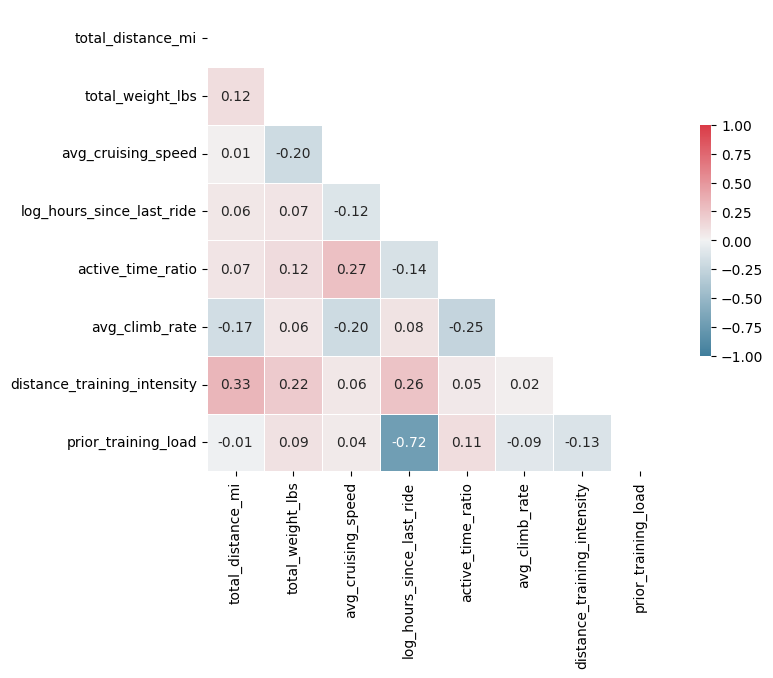

In [12]:
plot_feature_corr(df_corr_numerical, annotate=True)

In [13]:
print(f'There are {len(numerical_feature_cols+categorical_feature_cols)} features and {len(target_cols)} target columns')

There are 9 features and 17 target columns


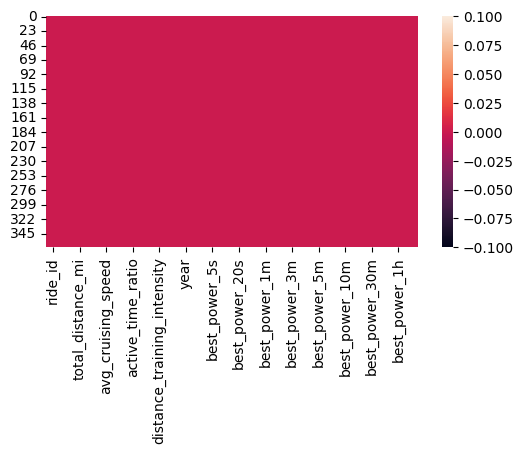

In [14]:
fig = plt.figure(figsize=(6,3))
_ = sns.heatmap(df_summary_selected.isna())